## Manual testing

Images to predict should be stored in **test_data** directory.

All predicted images will be moved to **predicted** folder and the prediction are the first 3 characters of filename.

Max 30 images will be shown in the plot grid.



In [2]:
import os
from PIL import Image 
import numpy as np
import tensorflow.keras as keras
import math
import matplotlib.pyplot as plt


def ziffer_data_files(input_dir='test_data'):
    imgfiles = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if (file.endswith(".jpg") ):
                #print(root + "/" + file)
                imgfiles.append(root + "/" + file)
    return  imgfiles

def ziffer_data(input_dir='test_data', use_grayscale=True):
    y_file = []
    y_data = []
    x_data = []
    files = ziffer_data_files(input_dir)
    y_data = np.array(y_data).reshape(-1,1)
    y_file = np.array(y_file).reshape(-1,1)
    if (use_grayscale):
        x_data = np.array(x_data).reshape(-1,32,20,1)
    else: 
        x_data = np.array(x_data).reshape(-1,32,20,3)

    for aktfile in files:
        base = os.path.basename(aktfile)
        if (base[1]=="."):
            target = base[0:3]
        else:
            target = base[0:1]
        if target == "N":
            category = 10                # NaN does not work --> convert to 10

        else:
            category = float(target)
        test_image = Image.open(aktfile).resize((20, 32))
        if (use_grayscale):
            test_image = test_image.convert('L')
        test_image = np.array(test_image, dtype="float32")
        test_image = test_image/255.
            
        #print(test_image.shape)
        if (use_grayscale):
            test_image = test_image.reshape(1,32,20,1)
        else:
            test_image = test_image.reshape(1,32,20,3)

        # ignore the category 10
        #if ( category<10):
        y_file = np.vstack((y_file, [base]))
        x_data = np.vstack((x_data, test_image))
        y_data = np.vstack((y_data, [category]))
    print("Ziffer data count: ", len(y_data))   
    return x_data, y_data, y_file

def move_to_pred_dir(prediction, filename, input_dirs=['test_data'], out_dir='predicted'):
    for input_dir in input_dirs:
        for root, dirs, files in os.walk(input_dir):
            for file in files:
                if file.startswith(filename):
                    shutil.move(os.path.join(root, file), os.path.join(out_dir,str(prediction)+"_"+file))


def class_encoding(y_train, nb_classes):
    ret = np.zeros((len(y_train), nb_classes))
    for i, y in enumerate(y_train):
        #print(i, y, int((y*10)))
        ret[i, int((y*10))] = 1
    return ret

def class_decoding(y_train, nb_classes=100):
    ret = np.zeros((len(y_train), 1))
    for i, y in enumerate(y_train):
        ret[i] = (np.argmax(y))/10
    return ret

def plot_dataset(images, labels, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    columns = 12
    rows = 5

    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels[i-1])  # set title
        if(images[i-1].shape[-1]==1):
            plt.imshow((images[i-1]), aspect='auto', cmap='gray')
        else:
            plt.imshow((images[i-1]), aspect='auto')
        plt.tight_layout()
    plt.show()

Ziffer data count:  586


2022-05-22 20:01:18.765317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


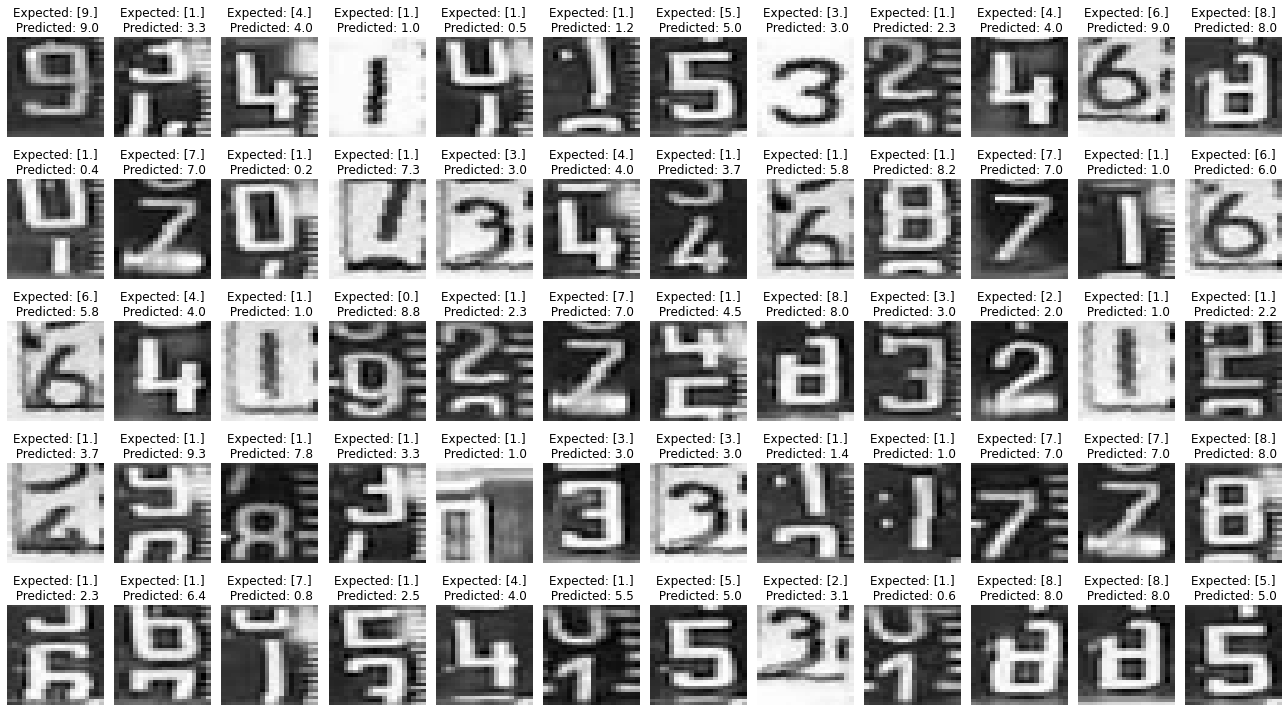

In [4]:
import numpy as np
import math
from operator import itemgetter
import shutil

img = []
pred_label = []

xz_data, yz_data, fz_data = ziffer_data('test_data',  use_grayscale=True)
input_shape=xz_data[0].shape


model = keras.models.load_model("eff100-gray.h5")

os.makedirs("predicted", exist_ok=True)

for x, y, filename in zip(xz_data, yz_data, fz_data):

    target = y
    classes = model.predict(np.expand_dims(x.reshape(input_shape), axis=0))
    out_target = class_decoding(classes).reshape(-1)[0]
    lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target)
           
                   
    img.append(x)
    pred_label.append(lbl_text)
    
    # can be used for labeling if comment in
    move_to_pred_dir(out_target, filename[0], out_dir='predicted' )

plot_dataset(np.array(img), pred_label, columns=11, rows=3)